In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import os
if not "milligrad" in os.listdir():
    os.chdir('..')

from milligrad import Tensor, Adam
from extras.mnist import load_mnist_data

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = load_mnist_data()

# flattening images and one-hot encoding labels
x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)
y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]

# normalizing
mean, std = x_train.mean(), x_train.std()
x_train, x_test = (x_train - mean) / std, (x_test - mean) / std


In [3]:
class MLP:
    def __init__(self):
        super().__init__()
        self.w1 = Tensor.xavier(784, 128)
        self.b1 = Tensor.randn(128)
        self.w2 = Tensor.xavier(128, 10)
        self.b2 = Tensor.randn(10)
        
    def __call__(self, x:Tensor)->Tensor:
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2

In [4]:
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

In [5]:
EPOCHS = 10
BATCH_SIZE = 128
LR = 1e-3


model = MLP()
optim = Adam([model.w1, model.b1, model.w2, model.b2], lr=LR)

losses = []
accuracies = []

for _ in tqdm(range(EPOCHS)):
    shuffle = np.random.permutation(len(x_train))
    
    for i in range(0, len(x_train)//BATCH_SIZE):
        indices = shuffle[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        x = Tensor(x_train[indices])
        y = Tensor(y_train[indices])
        y_hat = model(x)
        
        # This is simply the cross-entropy loss
        loss = -(y * y_hat.log_softmax()).sum(axis=-1).mean()

        losses.append(loss.data)
        accuracies.append(accuracy(y.data, y_hat.data))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
            

100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


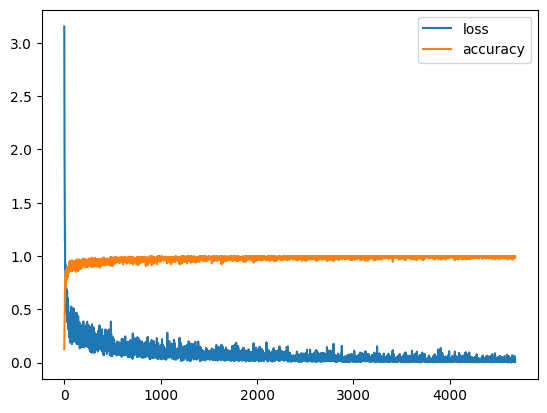

In [6]:
plt.plot(losses, label='loss')
plt.plot(accuracies, label='accuracy')
plt.legend()
plt.show()

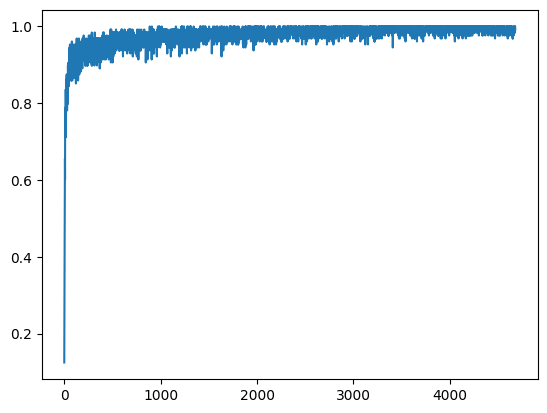

In [7]:
plt.plot(accuracies)

In [8]:
accuracy(y_test, model(Tensor(x_test)).data)

0.9763

4


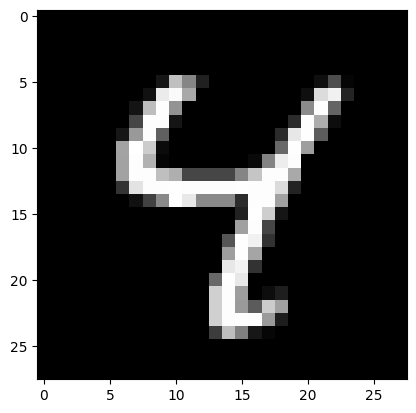

In [9]:
idx = 6

print(model(Tensor(x_test[idx])).data.argmax())

plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')